In [2]:
import numpy as np
import matplotlib.pyplot as plt


# LOAD THE LIST OF CLASSES
words = open("../data/speech-comands/classes.txt").read().split()

# LOAD THE TRAINING AND TEST DATA
data = np.load("../data/speech-comands/train.npz")
Xtrain = data["arr_0"]
Ytrain = data["arr_1"]
print(Xtrain.shape, Ytrain.shape)
data = np.load("../data/speech-comands/test.npz")
Xtest = data["arr_0"]
Ytest = data["arr_1"]
print(Xtest.shape, Ytest.shape)
spectrogram = Xtrain[0, :].reshape(20, 80)

(84291, 1600) (84291,)
(9376, 1600) (9376,)


## 1.1 Visualize the data

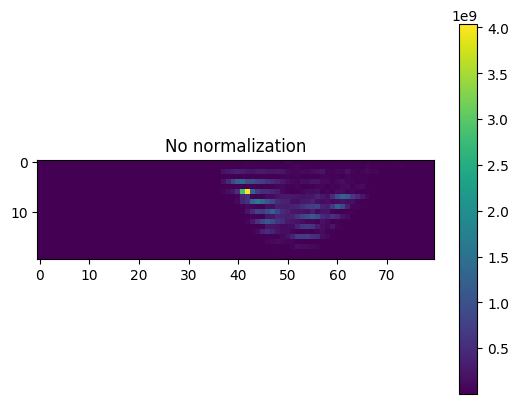

In [3]:
import trainmodel as tm
spectrogram_no_norm = Xtrain[0, :].reshape(20, 80)
plt.imshow(spectrogram_no_norm)
plt.colorbar()
plt.title("No normalization")
plt.show()

## 1.2 Feature normalization


Text(0.5, 1.0, 'whitening')

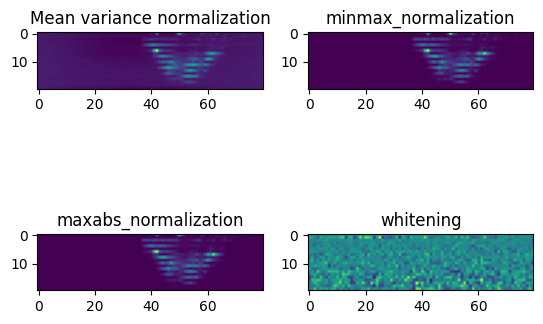

In [17]:
import trainmodel as tm

xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
spectrogram_mean_var = xTrainMV[0, :].reshape(20, 80)
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(spectrogram_mean_var)
axs[0, 0].set_title("Mean variance normalization")

xTrain, xTest = tm.minmax_normalization(Xtrain, Xtest)
spectrogram_min_max = xTrain[0, :].reshape(20, 80)

axs[0, 1].imshow(spectrogram_min_max)
axs[0, 1].set_title("minmax_normalization")

xTrainMA, xTestMA = tm.maxabs_normalization(Xtrain, Xtest)
spectrogram_max_abs = xTrainMA[0, :].reshape(20, 80)

axs[1, 0].imshow(spectrogram_max_abs)
axs[1, 0].set_title("maxabs_normalization")

xTrain, xTest = tm.whitening(Xtrain, Xtest)
spectrogram_whitning = xTrain[0, :].reshape(20, 80)

axs[1, 1].imshow(spectrogram_whitning)
axs[1, 1].set_title("whitening")

## 1.3 Train a neural network
Train a neural network for spoken digit recognition. Define and train a multilayer per-
ceptron without hidden layers. Train and evaluate it. Try with batch gradient descent
and with stochastic gradient descent with minibatches of different size.  
50 epoch 

In [ ]:
import trainmodel as tm
import pvml
import pandas as pd
xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
m = xTrainMV.shape[0]
net = pvml.MLP([1600, 35])
plt.ion()
train_accs = []
test_accs = []
batch_sizes = []
epochs = []
for batch_size in [10, 20, 50, 100, 200]:
    for epoch in range(50):
        net.train(xTrainMV, Ytrain, 1e-4, steps=m // batch_size,
                  batch=batch_size)
        if epoch % 10 == 0:
            train_acc = tm.accuracy(net, xTrainMV, Ytrain)
            test_acc = tm.accuracy(net, xTestMV, Ytest)
            print(epoch, train_acc, test_acc)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            batch_sizes.append(batch_size)
            epochs.append(epoch)
net.save("model.npz")
result = pd.DataFrame({'Train accuracy': train_accs,
                      'Test accuracy': test_accs, 'Batch size': batch_sizes,"epoch":epochs})
result.to_csv("accuracies_diff_batch_size.csv", index=True)
result=result.pivot(index="epoch",columns="Batch size",values="Test accuracy")
result.plot(x="epoch", y="Test accuracy", kind="line")

<Axes: title={'center': 'Test accuracy vs epoch for different batch sizes'}, xlabel='epoch', ylabel='Test accuracy'>

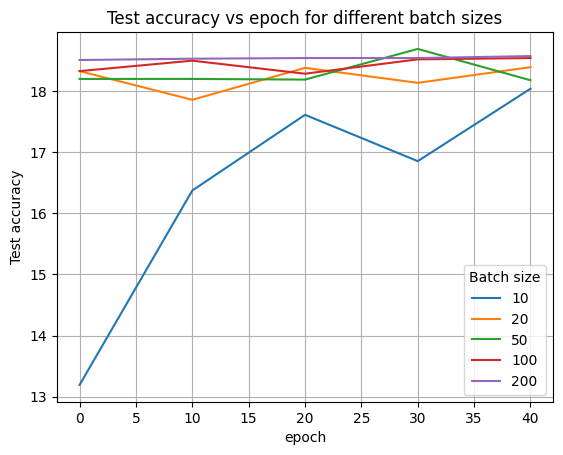

In [18]:
result=pd.read_csv("accuracies_diff_batch_size.csv")
result=result.pivot(index="epoch",columns="Batch size",values="Test accuracy")
result.plot(kind="line",grid=True, title="Test accuracy vs epoch for different batch sizes", ylabel="Test accuracy") 


## 1.4 Network architecture

Add one or more hidden layers. Try with layers of different width. What is the best
architecture for this problem?

50 epoch

| Hidden layers | Structure                 |
| ------------- | ------------------------- |
| 0             | 1600 + 35                 |
| 1             | 1600 + 256 + 35           |
| 1             | 1600 + 128 + 35           |
| 1             | 1600 + 56 + 35            |
| 2             | 1600 + 256 + 128 + 35     |
| 2             | 1600 + 256 + 56 + 35      |
| 3             | 1600 + 256 + 128 + 56 +35 |


In [ ]:
import trainmodel as tm
import pvml
import pandas as pd
xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
train_accs = []
test_accs = []
epochs = []
lambdas = []
batch_size = 100
structures = [[1600, 35], [1600, 256, 35], [1600, 128, 35], [1600, 56, 35], [1600, 256, 128, 35], [1600, 256, 56, 35], [1600, 256, 128, 56, 35]]
m = xTrainMV.shape[0]
for structure in structures:
    print(structure)
    net = pvml.MLP(structure)
    for epoch in range(51):
        net.train(xTrainMV, Ytrain, 1e-4, steps=m // batch_size,
                  batch=batch_size)
        if epoch % 10 == 0:
            train_acc = tm.accuracy(net, xTrainMV, Ytrain)
            test_acc = tm.accuracy(net, xTestMV, Ytest)
            print(epoch, train_acc, test_acc)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            structures.append(structure)
            epochs.append(epoch)
            lambdas.append(0.00001)

    net.save("model"+str(structure)+"50_iter_normal.npz")


result = pd.DataFrame({'Train accuracy': train_accs,
                      'Test accuracy': test_accs, 'Structure': structures, "Epoch": epochs})
result.to_csv("accuracies_diff_structures.csv", index=True)

<Axes: title={'center': 'Train accuracy vs epoch for different structures of the network'}, xlabel='Epoch', ylabel='Test accuracy'>

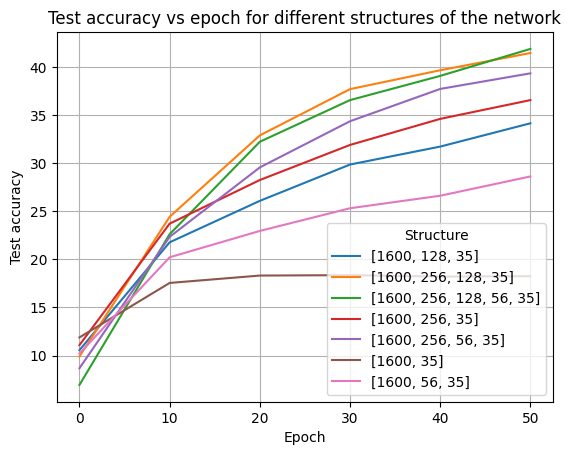

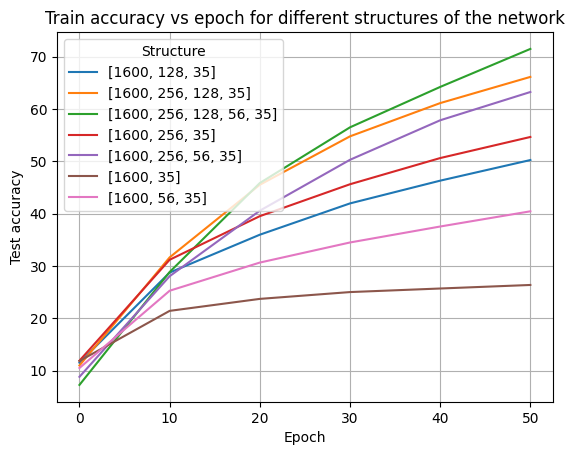

In [50]:
import pandas as pd
result=pd.read_csv("accuracies_diff_structure.csv",sep=";")
result1=result.pivot(index="Epoch",columns="Structure",values="Test accuracy")
result1.plot(kind="line",grid=True, title="Test accuracy vs epoch for different structures of the network", ylabel="Test accuracy") 

result2=result.pivot(index="Epoch",columns="Structure",values="Train accuracy")
result2.plot(kind="line",grid=True, title="Train accuracy vs epoch for different structures of the network", ylabel="Test accuracy") 



## Find the optimal value for lambda

In [52]:
import trainmodel as tm
import pvml
import pandas as pd
xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
train_accs = []
test_accs = []
epochs = []
lambdas = []
batch_size = 100
structure = [1600, 256, 128, 35]
structures=[]
lambdas = []
m = xTrainMV.shape[0]
net = pvml.MLP(structure)
for lambda_ in [0.0001, 0.001, 0.01,0.1]:
    print(lambda_)
    for epoch in range(51):
        net.train(xTrainMV, Ytrain, 1e-4, steps=m // batch_size,
                  batch=batch_size)
        if epoch % 10 == 0:
            train_acc = tm.accuracy(net, xTrainMV, Ytrain)
            test_acc = tm.accuracy(net, xTestMV, Ytest)
            print(epoch, train_acc, test_acc)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            structures.append(structure)
            epochs.append(epoch)
            lambdas.append(lambda_)

    net.save("model"+str(structure)+"50_iter_"+str(lambda_)+".npz")


result = pd.DataFrame({'Train accuracy': train_accs,
                      'Test accuracy': test_accs, 'Structure': structures, "Epoch": epochs, "Lambda": lambdas})
result.to_csv("accuracies_diff_lambda.csv", index=True)

0 10.212240927263885 9.545648464163822
10 32.44711772312584 24.328071672354948
20 45.386814725178255 32.67918088737201
30 54.00695210639333 36.64675767918089
40 60.94600847065523 39.729095563139936
50 65.4909776844503 41.13694539249147


<Axes: title={'center': 'Train accuracy vs epoch for different structures of the network'}, xlabel='Epoch', ylabel='Test accuracy'>

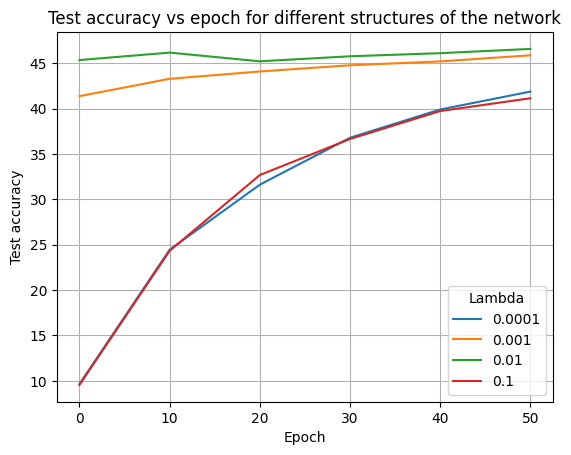

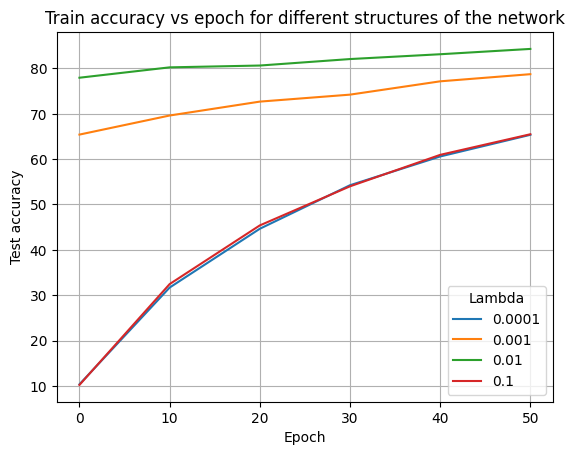

In [53]:
import pandas as pd
result=pd.read_csv("accuracies_diff_lambda.csv",sep=";")
result1=result.pivot(index="Epoch",columns="Lambda",values="Test accuracy")
result1.plot(kind="line",grid=True, title="Test accuracy vs epoch for different structures of the network", ylabel="Test accuracy") 

result2=result.pivot(index="Epoch",columns="Lambda",values="Train accuracy")
result2.plot(kind="line",grid=True, title="Train accuracy vs epoch for different structures of the network", ylabel="Test accuracy")

## 1.5 Analysis

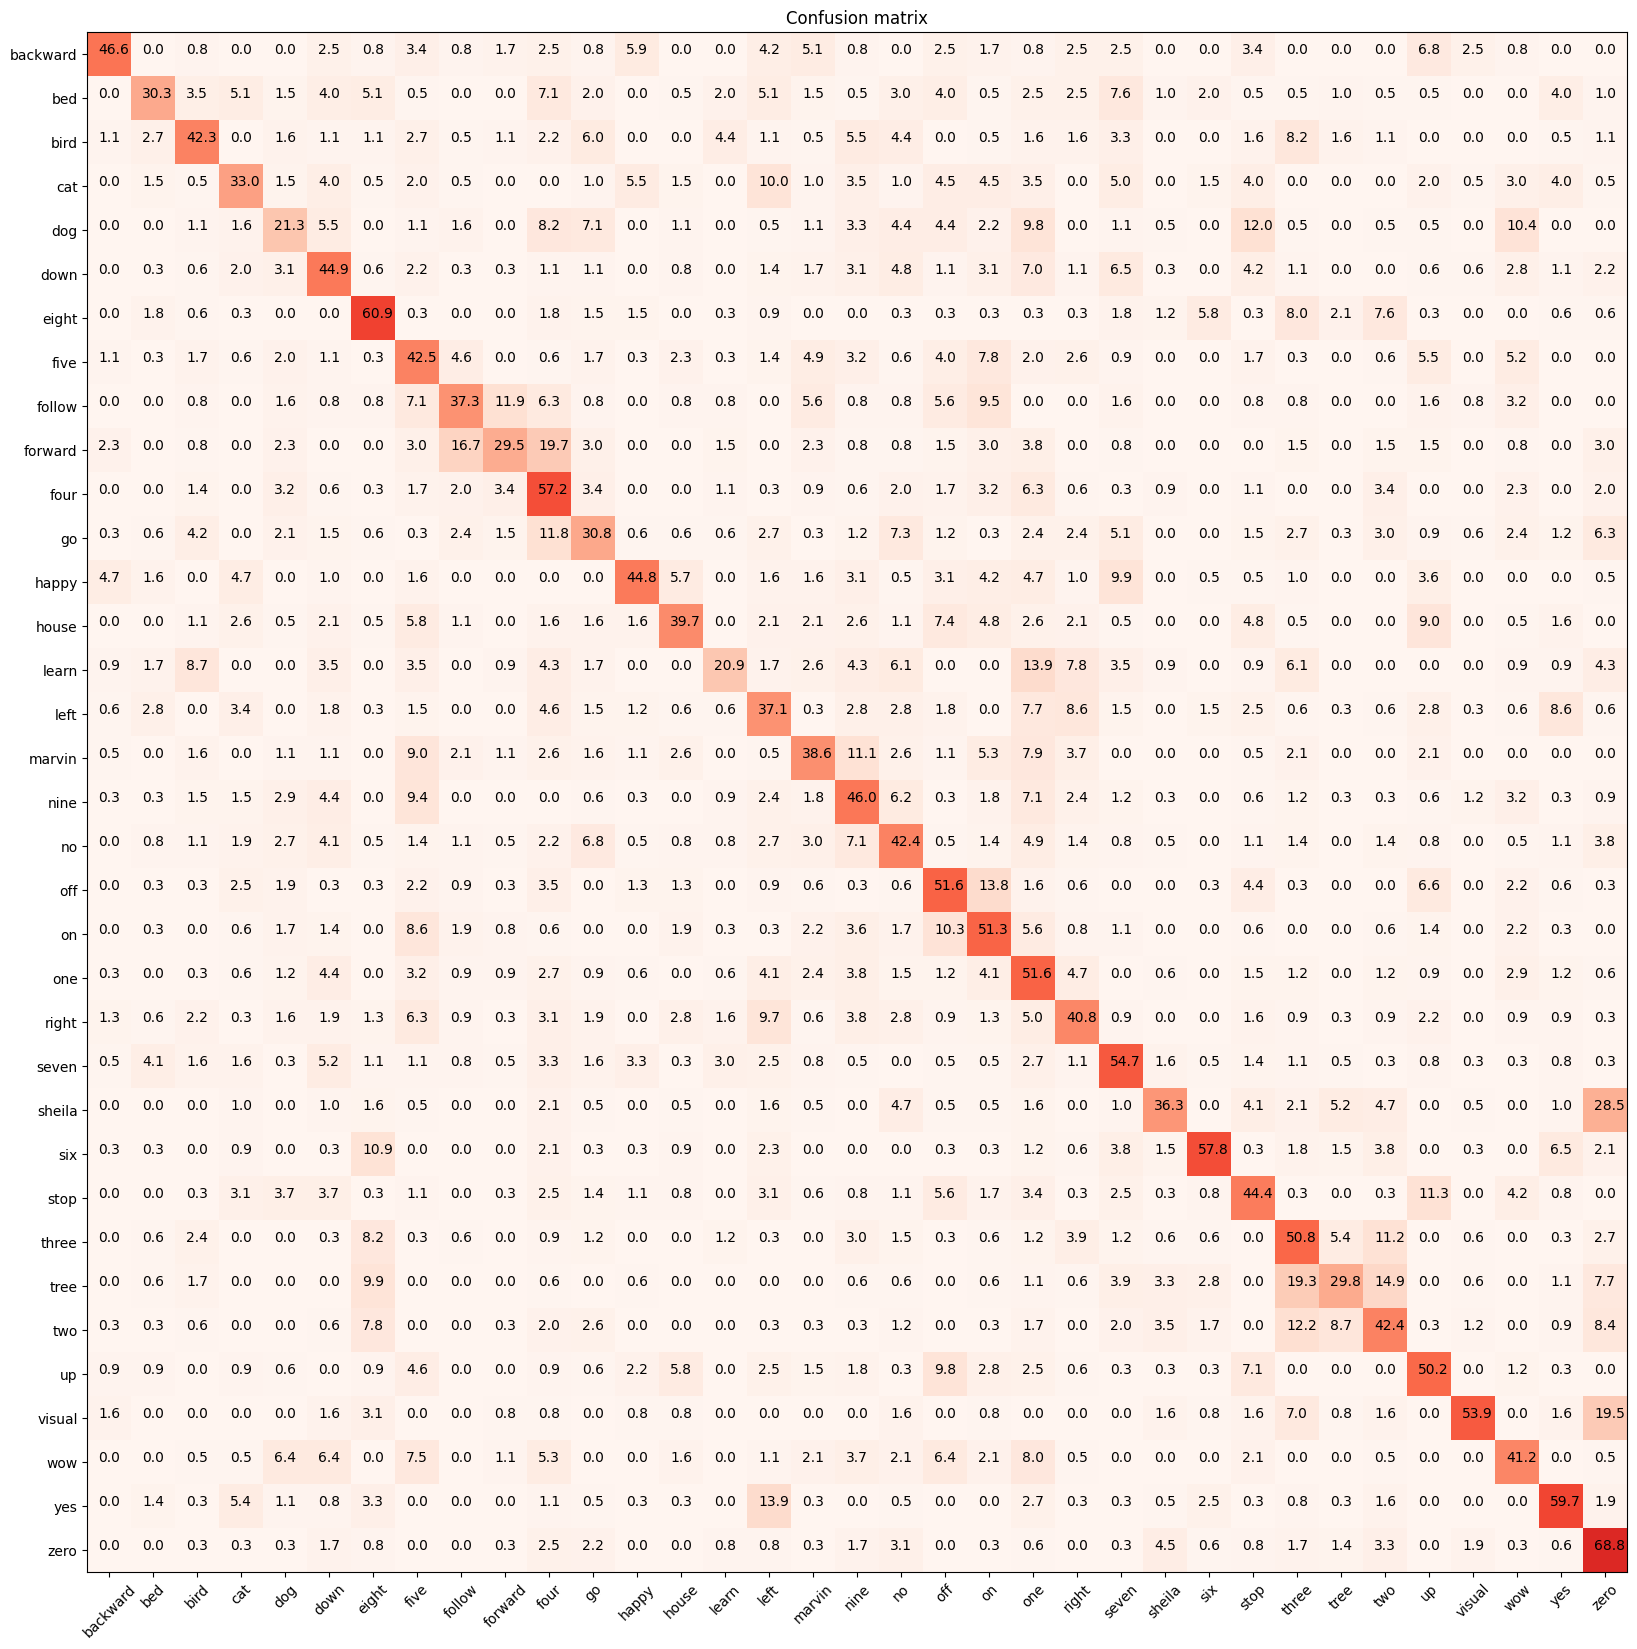

In [54]:
import analysis as an
import trainmodel as tm
import pvml
xTrainMV, xTestMV = tm.mean_variance_normalization(Xtrain, Xtest)
network = pvml.MLP.load("model[1600, 256, 128, 35]50_iter_0.001.npz")
predictions, logits = network.inference(xTestMV)
cmat = an.make_confusion_matrix(predictions, Ytest)
an.show_confusion_matrix(Ytest, predictions, words)